AUTHOR: [@sparshsah](github.com/sparshsah)

# BOND STATS

I propose the following approximation: `irr` $\approx$ `coupon - loss - premium / wal`, where
* `irr` is internal rate of return (annualized);
* `coupon` is coupon fraction (annualized);
* `loss` is (gross-of-recoveries) loss rate (annualized);
* `premium` is the premium (if positive) or discount (if negative) paid, in percentage points; and
* `wal` is weighted-average life.

For simplicity, I neglect recoveries, which makes net-of-recoveries loss rate the same as `loss`. WLOG, I assume initial principal is \$1 and payments are made at the end of each year (this is WLOG because instead of an Earth year, you can make the unit of time anything you want, and call that your year).

I'd like to know how good this approximation is under various
* Amortization schedules
* Coupons
* Loss rates
* Premia
* Terms.

In [138]:
from typing import Final

import numpy as np
import pandas as pd

import foggy_statslib

In [84]:
ORIG_PRIN: Final[float] = 1.00

In [228]:
def _get_pmts(
    amort: bool = False,
    term: int = 1,
    loss_rate: float = 0.00,
    coupon_frac: float = 0.00,
    orig_prin: float = ORIG_PRIN,
    px: float = 1.00,
) -> pd.DataFrame:
    """DF(index=timesteps, columns=["prin", "chargeoff", "coupon"])."""
    pmts = pd.DataFrame(
        index=range(0, term+1),
        columns=["prin", "chargeoff", "coupon"],
    )
    # special row
    pmts.loc[0, :] = pd.Series({"prin": -px*orig_prin, "chargeoff": 0, "coupon": 0})
    bal = orig_prin
    for t in range(1, term+1):
        pmts.loc[t, "coupon"] = bal * coupon_frac
        pmts.loc[t, "chargeoff"] = bal * loss_rate
        bal -= pmts.loc[t, "chargeoff"]
        ####
        if amort:
            # beginning-of-period remaining term -- fencepost principle
            rterm = term - t + 1
            pmts.loc[t, "prin"] = bal / rterm
        else:
            pmts.loc[t, "prin"] = 0 if t < term else bal
        bal -= pmts.loc[t, "prin"]       
    assert np.isclose(bal, 0), f"Balance should be zero, is {bal}!"
    # augment column
    pmts.loc[:, "net"] = pmts.sum(axis="columns")
    return pmts

def _calc_wal(
    pmts_prin: pd.Series,
    orig_prin: float = ORIG_PRIN,
) -> float:
    pmts_prin_postorig = pmts_prin.loc[1:] 
    wal = (
        pmts_prin_postorig.index.to_numpy()
        * pmts_prin_postorig.to_numpy()
    ).sum()
    return wal

def _calc_npv(
    pmts_net: pd.Series,
    r: float = 0.10,
) -> float:
    numerator = pmts_net.to_numpy()
    denominator = (1+r)**pmts_net.index.to_numpy()
    dcf = numerator / denominator
    npv = dcf.sum()
    return npv

def _calc_true_irr(
    pmts_net: pd.Series,
    interval: float = 0.01,  # 1pct
) -> float:
    # fricking NumPy moved theirs
    for irr in np.arange(-0.20, 0.20, interval):
        npv = _calc_npv(
            pmts_net=pmts_net,
            r=irr,
        )
        if npv < 0:
            break
    irr = irr + interval/2
    return irr

def _calc_approx_irr(
    wal: float,
    loss_rate: float,
    coupon_frac: float,
    px: float = 1,
) -> float:
    # adjustment for e.g. 100-year ZCB's with high ANL's:
    # if wal < term/3, use term/3
    adj_wal = max(wal, term/3)
    return coupon_frac - loss_rate - (px - 1)/adj_wal

TERM_DOMAIN: Final[list[int]] = [1, 2, 5, 10, 20, 30, 100]
LOSS_RATE_DOMAIN: Final[list[float]] = [0, 0.01, 0.05, 0.10, 0.25, 0.50]
COUPON_FRAC_DOMAIN: Final[list[float]] = [0, 0.01, 0.05, 0.10, 0.25, 0.50]
PX_DOMAIN: Final[list[float]] = [0.75, 0.90, 0.95, 1, 1.05, 1.10, 1.25]

def ana_one(
    amort: bool = False,
    term: int = 1,
    loss_rate: float = 0.00,
    coupon_frac: float = 0.00,
    orig_prin: float = ORIG_PRIN,
    px: float = 1.00,
) -> pd.DataFrame:
    pmts = _get_pmts(
        amort=amort,
        term=term,
        loss_rate=loss_rate,
        coupon_frac=coupon_frac,
        orig_prin=orig_prin,
        px=px,
    )
    wal = _calc_wal(
        pmts_prin=pmts["prin"],
        orig_prin=orig_prin,
    )
    true_irr = _calc_true_irr(
        pmts_net=pmts["net"],
    )
    approx_irr = _calc_approx_irr(
        wal=wal,
        loss_rate=loss_rate,
        coupon_frac=coupon_frac,
        px=px,
    )
    return pd.DataFrame(
        {
            "true": true_irr,
            "approx": approx_irr,
        },
        index=pd.MultiIndex.from_tuples(
            tuples=[
                (
                    amort,
                    term,
                    loss_rate,
                    coupon_frac,
                    orig_prin,
                    px,
                ),
            ],
            names=["amort", "term", "loss_rate", "coupon_frac", "orig_prin", "px"],
        ),
    )

def ana_many(
    amort: bool = False,
    orig_prin: float = ORIG_PRIN,
) -> pd.DataFrame:
    return pd.concat(
        [
            ana_one(
                amort=amort,
                term=term,
                loss_rate=loss_rate,
                coupon_frac=coupon_frac,
                orig_prin=orig_prin,
                px=px,
            )
            for term in TERM_DOMAIN
            for loss_rate in LOSS_RATE_DOMAIN
            for coupon_frac in COUPON_FRAC_DOMAIN
            for px in PX_DOMAIN
        ],
        verify_integrity=True,
    )

In [229]:
def plot(df: pd.DataFrame) -> None:
    # x values are discretized bc i do a discrete search
    foggy_statslib.core.plot(
        df,
        kind="scatter",
        x="true",
        y="approx",
        c="blueviolet",
        alpha=0.10,
        xpct=True,
        ypct=True,
        title=f"""Corr = {df.corr()["true"]["approx"]:.2f}""",
    )

## Non-amortizing

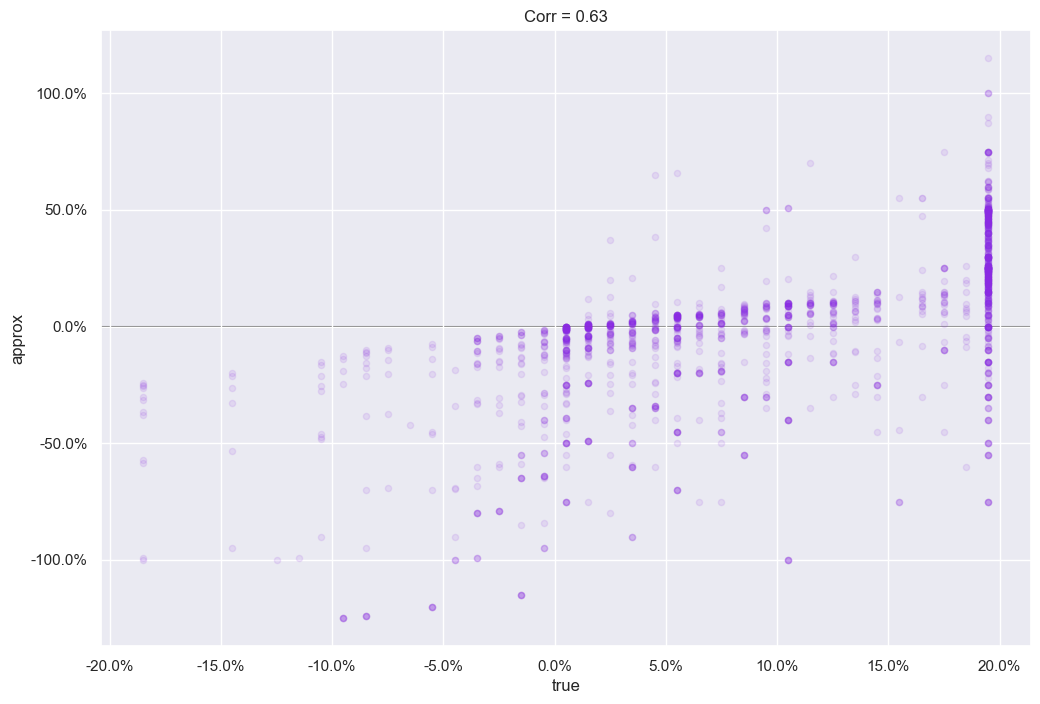

In [230]:
df = ana_many()
plot(df)

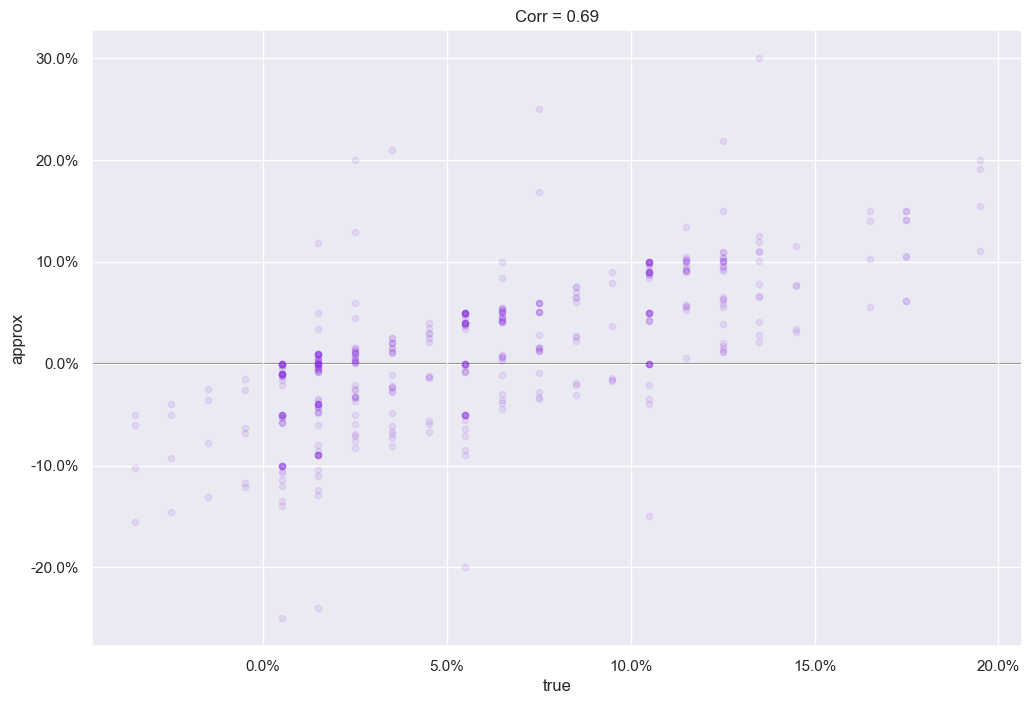

In [264]:
keeper = df.index.to_frame()
keeper = (
    (keeper["loss_rate"] < 0.25)
    & (keeper["coupon_frac"] < 0.25)
    & (
        (keeper["px"] - 1).abs()
        < 0.10
    )
)
plot(df.loc[keeper, :])

In [243]:
foo = df
foo = foo.loc[(foo["true"] > 0.19) & (foo["approx"].abs() > 0.70), :]
foo

true    approx
amort term loss_rate coupon_frac orig_prin px                   
False 1    0.00      0.50        1.0       0.75  0.195  0.750000
           0.01      0.50        1.0       0.75  0.195  0.742525
           0.05      0.50        1.0       0.75  0.195  0.713158
      5    0.50      0.50        1.0       0.75  0.195  0.750000
                                           1.25  0.195 -0.750000
      10   0.50      0.50        1.0       0.75  0.195  0.750000
                                           1.25  0.195 -0.750000
      20   0.25      0.25        1.0       0.75  0.195  0.750000
                     0.50        1.0       0.75  0.195  1.000000
           0.50      0.50        1.0       0.75  0.195  0.750000
                                           1.25  0.195 -0.750000
      30   0.25      0.25        1.0       0.75  0.195  0.750000
                     0.50        1.0       0.75  0.195  1.000000
           0.50      0.50        1.0       0.75  0.195  0.750000
                                           1.25  0.195 -0.750000
      100  0.05      0.50        1.0       0.75  0.195  0.872260
           0.10      0.25        1.0       0.75  0.195  0.900000
                     0.50        1.0       0.75  0.195  1.150000
           0.25      0.25        1.0       0.75  0.195  0.750000
                     0.50        1.0       0.75  0.195  1.000000
           0.50      0.50        1.0       0.75  0.195  0.750000
                                           1.25  0.195 -0.750000

In [239]:
foo.describe()

,true,approx
count,2.130000e+02,213.000000
mean,1.950000e-01,0.422344
std,2.782096e-17,0.334487
min,1.950000e-01,-0.750000
25%,1.950000e-01,0.450000
50%,1.950000e-01,0.490000
75%,1.950000e-01,0.511031
max,1.950000e-01,1.150000


## Amortizing

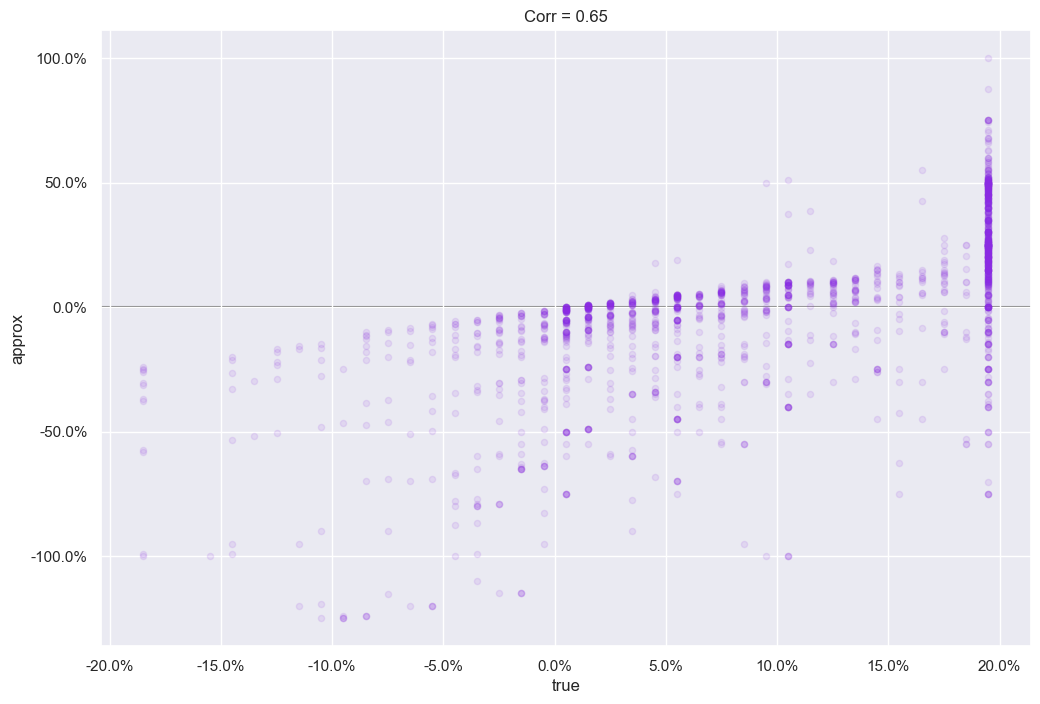

In [232]:
df_ = ana_many(amort=True)
plot(df_)

In [236]:
foo = df_
foo = foo.loc[(foo["true"] > 0.19) & (foo["approx"].abs() > 0.40), :]
foo

true  approx
amort term loss_rate coupon_frac orig_prin px                 
True  1    0.0       0.25        1.0       0.75  0.195    0.50
                     0.50        1.0       0.75  0.195    0.75
                                           0.90  0.195    0.60
                                           0.95  0.195    0.55
                                           1.00  0.195    0.50
...                                                ...     ...
      100  0.5       0.25        1.0       0.75  0.195    0.50
                                           1.05  0.195   -0.40
                                           1.10  0.195   -0.55
                     0.50        1.0       0.75  0.195    0.75
                                           1.25  0.195   -0.75

[203 rows x 2 columns]

In [237]:
foo.describe()

,true,approx
count,2.030000e+02,203.000000
mean,1.950000e-01,0.433281
std,2.782419e-17,0.287294
min,1.950000e-01,-0.750000
25%,1.950000e-01,0.450000
50%,1.950000e-01,0.490000
75%,1.950000e-01,0.509629
max,1.950000e-01,1.000000


## More realistic domain

In [223]:
TERM_DOMAIN: Final[list[int]] = [1, 2, 5, 10, 20, 30]
LOSS_RATE_DOMAIN: Final[list[float]] = [0, 0.01, 0.05, 0.10, 0.20, 0.30]
COUPON_FRAC_DOMAIN: Final[list[float]] = [0, 0.01, 0.05, 0.10, 0.20, 0.30]
PX_DOMAIN: Final[list[float]] = [0.75, 0.90, 0.95, 1, 1.05]

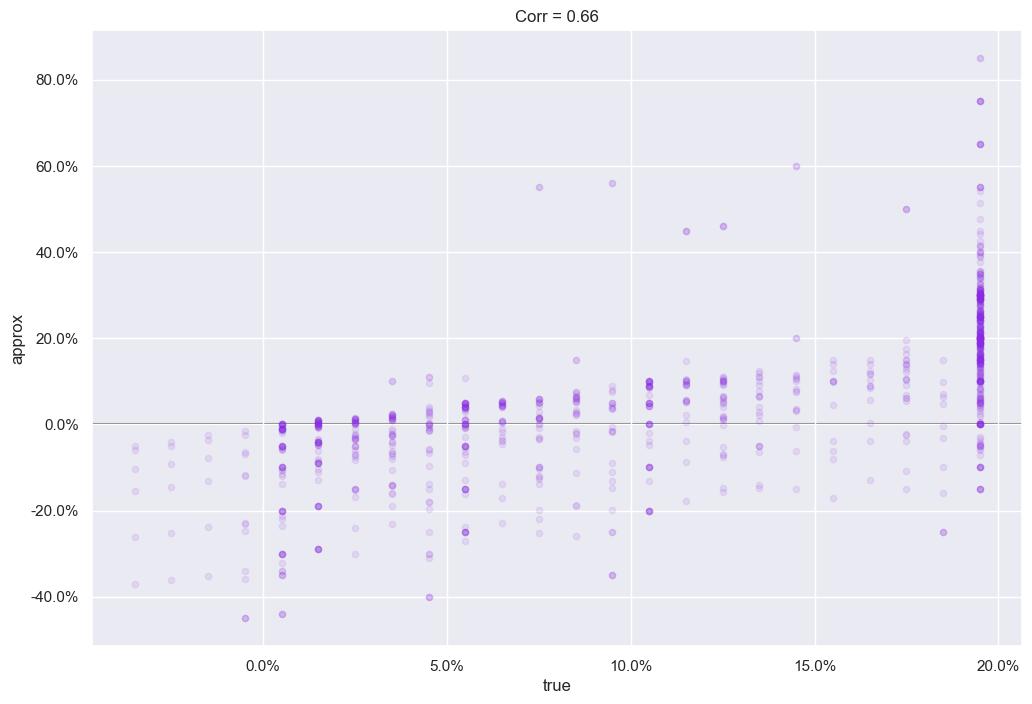

In [224]:
plot(ana_many(amort=False))

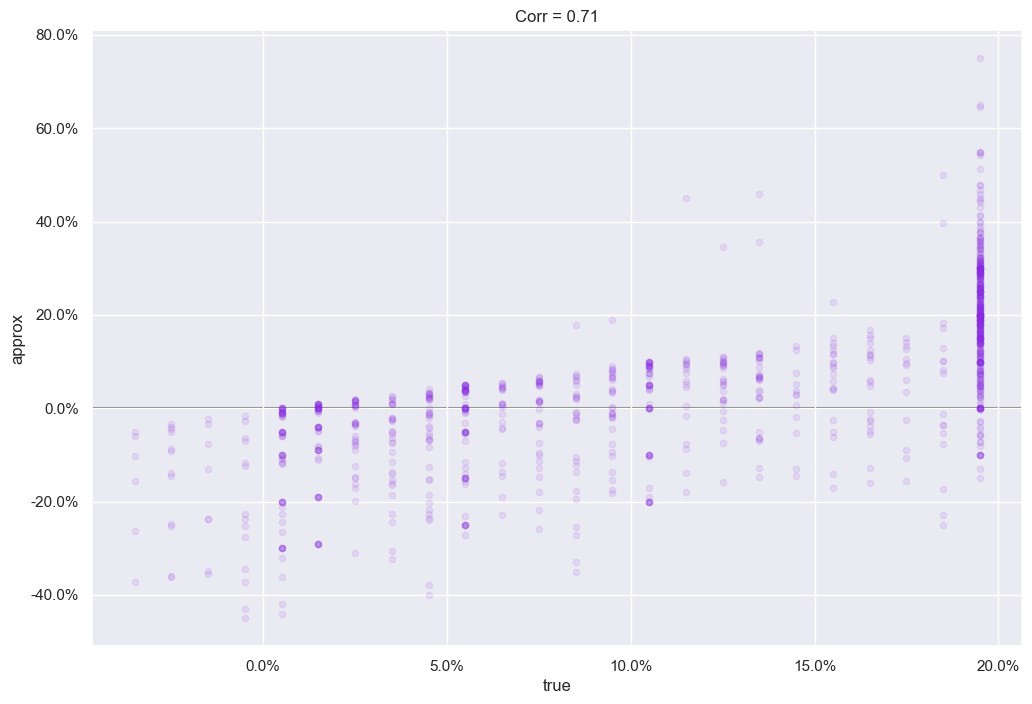

In [219]:
plot(ana_many(amort=True))